## Variability Depth

This metric was written by Keaton Bell (keatonb@astro.as.utexas.edu) to assess the survey depth (magnitude) to which variability of a given amplitude can be overwhelmingly detected. This question of *whether* a target is variable is most fundamental to the study of variability with LSST and is prerequisite to the measurements of other variability parameters (e.g., pulsation periods). Analysis of survey data with an approach similar (but admittedly more sophisticated) to that outlined here will uncover the maximum number of variable sources in LSST with reasonably well understood completenesses. The magnitude limits calculated by this metric are particularly important as they represent the depth to which short-period (< ~revisit time), multi-periodic and/or low-amplitude pulsators can be detected in LSST. For the short-period case, or any time that observational epochs are assumed to be randomly distributed in phase, detection of excess photometric scatter over the calibrated photometric error can yield a measure of total pulsational power. This is of particular interest for studying the energetics of pulsating white dwarf stars through the six-filter parameter space of the instability strips.

In [1]:
#import general things
import numpy as np 
from scipy.stats import chi2
from scipy.interpolate import UnivariateSpline, interp1d
import matplotlib.pyplot as plt
%matplotlib inline

#import lsst things
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.maf.metrics import BaseMetric

This metric relies on the calculated 'fiveSigmaDepth' and the total number of visits in a given filter. The metric uses these values from the OpSIM output, but in demonstrating the derivation of the metric here, I will use some arbitrary example values.

In [2]:
# 5 sigma depth
m5 = np.random.rand(200)*2.+23. #200 observations with 5sigma depths uniformily distributed between mag 23 and 25
N = len(m5) # number of visits
N

200

To give an illustrative example of what the source recovery fraction would look like for stars of an arbitrary magnitude, we consider the m=18 case:

In [3]:
mref = 18.

At the fiveSigmaDepth, m5, the photometric signal-to-noise (S/N) is 5. The fractional standard deviation (sigma) in the measured flux is then 1/(S/N) = 0.2.

Since photometric S/N scales as sqrt(Flux), and the fractional difference in flux between m5 and mref is equal to 10^(0.4(m5-mref))

In [4]:
sigma = 0.2 * (10.**(-0.2*m5)) * (10.**(0.2*mref)) # Flux standard error for star of magnitude mref
print np.mean(sigma)

0.0134327217926


We're going to assume for this simulation that the photometric errors are distributed as Gaussians. This isn't such a crazy assumption; since photometric uncertainty is influenced by a large number of factors (seeing, clouds, dust, sky brightness, pixel sensitivity, etc.), the central limit theorem supports that their combined effects approach a Gaussian.

We will compare the liklihoods that a measured variance of a set of flux observations arises from either purely measurement error of a source of constant brightness versus the combined effect of measurement error and intrinsic variability.

We assess our ability to recover Normally distributed intrinsic variability with a standard deviation of 1%. This is of order the variability expected from low-amplitude pulsating white dwarfs, and the central limit theorem supports that these multi-periodic pulsators have intrinsic brightness variations that are approximately Normally distributed.

In [5]:
signal = 0.01 # 1% intrinsic standard deviation

I found an analytic solution for the probablility density functions for noise-only and signal-plus-noise variances to be intractable.  We proceed by directly simulating the measurements, which is not very computationally expensive.

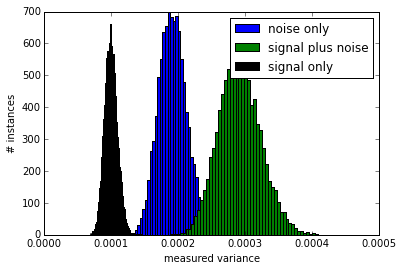

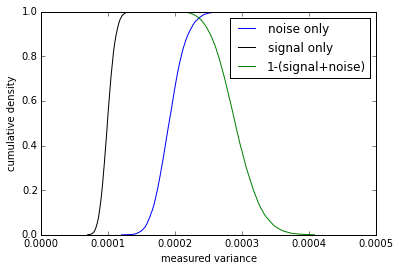

In [6]:
#Let's try directly simulating a bunch of standard deviations, both with and without signal.
numruns = 10000 # simulate numruns realizations of these observations

noiseonlyvar = np.zeros(numruns) # hold the measured noise-only variances 
noiseandsignalvar = np.zeros(numruns) # hold the measured noise-plus-signal variances 
signalonlyvar = np.zeros(numruns) #temporary for testing

#Simulate the measured variances
for i in np.arange(numruns):
    scatter = np.random.randn(N)*sigma # random realization of the Gaussian error distributions
    sig = np.random.randn(N)*signal #random realization of the underlying variable signal
    noiseonlyvar[i] = np.var(scatter) # store the noise-only variance
    signalonlyvar[i] = np.var(sig) # store the signal-only variance
    noiseandsignalvar[i] = np.var(sig+scatter) # store the noise-plus-signal variance
    
#plot the histograms of measured variances:
plt.hist(noiseonlyvar,bins=50,label='noise only',color='blue')
plt.hist(noiseandsignalvar,bins=50,label='signal plus noise',color='green')
plt.hist(signalonlyvar,bins=50,label='signal only',color='black')
plt.xlabel('measured variance')
plt.ylabel('# instances')
plt.xlim(0.00,0.0005)
plt.legend()
plt.show()

#Plot the cumulative density functions
plt.plot(np.sort(noiseonlyvar),np.arange(numruns)/float(numruns),label='noise only',color='blue') # noise only
plt.plot(np.sort(signalonlyvar),np.arange(numruns)/float(numruns),label='signal only',color='black') # signal only
plt.plot(np.sort(noiseandsignalvar),1.-np.arange(numruns)/float(numruns),label='1-(signal+noise)',color='green') # 1-(signal+noise)
plt.xlabel('measured variance')
plt.ylabel('cumulative density')
plt.xlim(0.00,0.0005)
plt.legend()
plt.show()

We see that the measured variance tends to be higher for stars with underlying signal (as expected!), but there is some magnitude-dependent overlap between the distributions that will lead to confusion.

This metric employs a classification scheme that makes a cut on measured variability and identifies everything above the cut as intrinsically variable, and everything below as likely noise only.

Specifically, we will demand that we recover 95% of the variable sources (sample is 95% complete).  We will then calculate the magnitude where only 5% of the noise-only sources contaminate this sample.  The actual false alarm probability depends on the relative numbers of variable and non-variable sources, and this measurement is far more complicated in reality where there is a continuum of allowed intrinsic flux variances and probability density functions.  However, more highly variable sources will generally be recovered more easily and less variable sources will be recovered less often, and I think this scheme characterizes the magnitude limit for detecting new low-amplitude variables fairly accurately.

In [7]:
completeness = .95 # fraction of variable sources recovered
contamination = .05 # fraction of non-variable sources that are misclassified

To find this magnitude limit, we simulate the overlap between the variance distributions for numerous test magnitudes between the LSST bright limit (m=16) and the single visit depth (m~24.5, as determined by the calculated m5 depth).  We then interpolate to approximate where the completeness and contamination limits coincide.

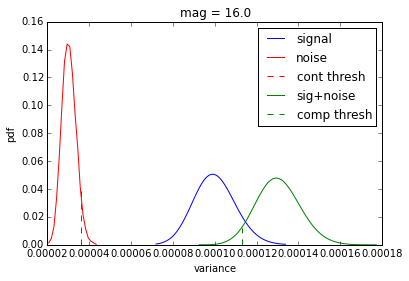

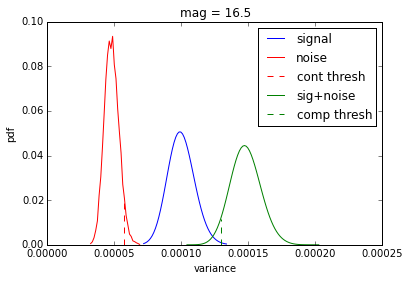

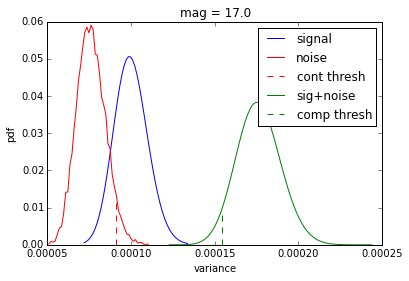

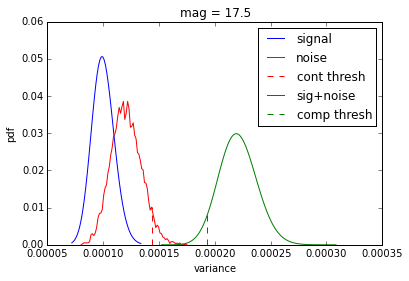

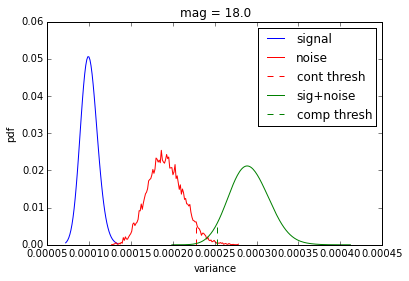

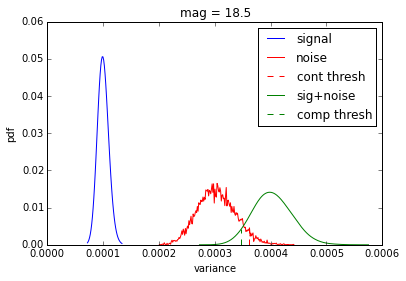

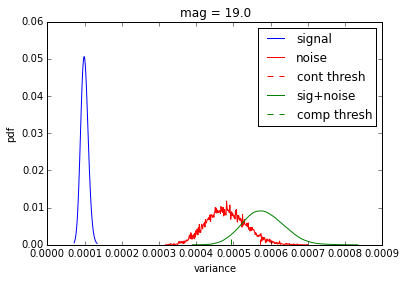

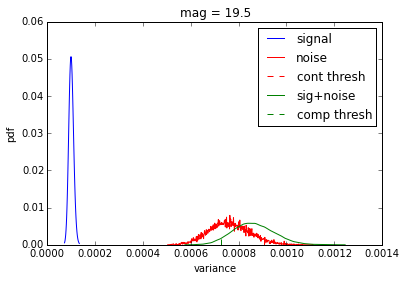

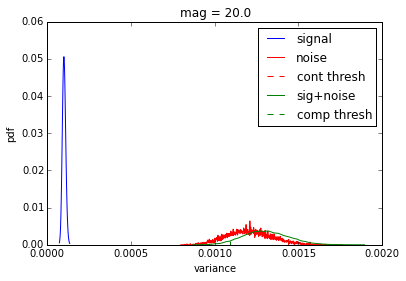

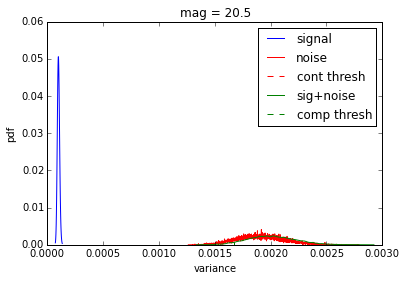

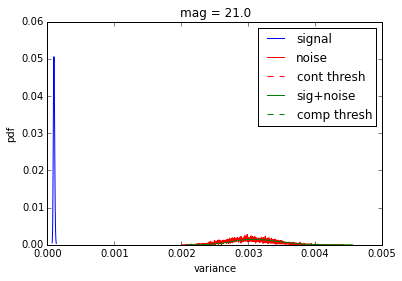

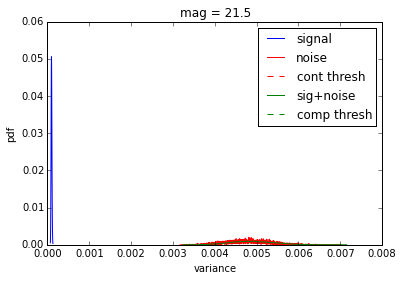

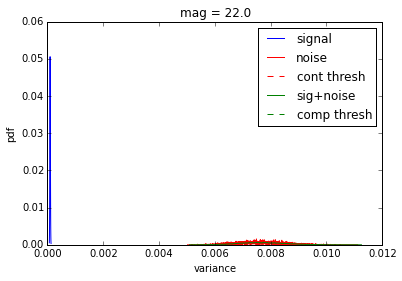

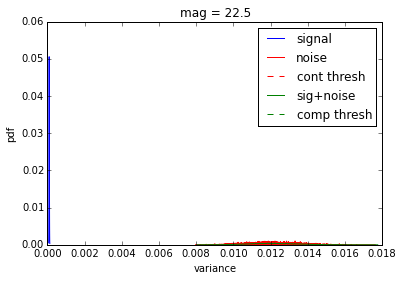

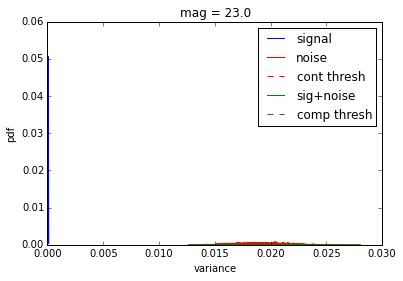

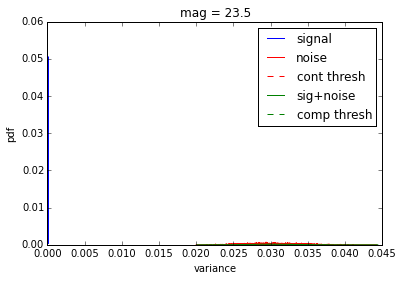

In [8]:
#%%timeit #This is the computationally expensive part, but hopefully not too bad.
#1 loops, best of 3: <300 ms per loop

mag = np.arange(16,np.mean(m5),0.5) #magnitudes to be sampled
res = np.zeros(mag.shape) #hold the distance between the completeness and contamination goals.

noiseonlyvar = np.zeros(numruns) # hold the measured noise-only variances 

#Calculate the variance at a reference magnitude and scale from that
m0=20.
sigmaref = 0.2 * (10.**(-0.2*m5)) * (10.**(0.2*m0))

#run the simulations
#Simulate the measured noise-only variances at a reference magnitude
for i in np.arange(numruns):
    scatter = np.random.randn(N)*sigmaref # random realization of the Gaussian error distributions
    noiseonlyvar[i] = np.var(scatter) # store the noise-only variance

#Since we are treating the underlying signal being representable by a fixed-width gaussian,
#its variance pdf is a Chi-squared distribution with the degrees of freedom = visits.
#Since variances add, the variance pdfs convolve.

#We'll use the cdf of the noise-only variances because it's easier to interpolate
noisesorted = np.sort(noiseonlyvar)
interpnoisecdf = UnivariateSpline(noisesorted,np.arange(numruns)/float(numruns),k=1,s=0) #linear

#We need a binned, signal-only variance probability distribution function for numerical convolution
numsignalsamples = 50
xsig = np.linspace(chi2.ppf(0.001, N),chi2.ppf(0.999, N),numsignalsamples)
signalpdf = chi2.pdf(xsig, N)
#correct x to the proper variance scale
xsig = (signal**2.)*xsig/N
pdfstepsize = xsig[1]-xsig[0]
#Since everything is going to use this stepsize down the line,
#normalize so the pdf integrates to 1 when summed (no factor of stepsize needed)
signalpdf /= np.sum(signalpdf)

#run through the sample magnitudes, calculate distance between cont and comp thresholds
for i,mref in enumerate(mag): #i counts and mref is the currently sampled magnitude
    #Scale factor from m0
    scalefact = 10.**(0.4*(mref-m0))
    
    #Calculate the desired contamination threshold
    contthresh = np.percentile(noiseonlyvar,100.-100.*contamination)*scalefact
    
    #Realize the noise CDF at the required stepsize
    xnoise = np.arange(noisesorted[0]*scalefact,noisesorted[-1]*scalefact,pdfstepsize)
    noisecdf = interpnoisecdf(xnoise/scalefact)
    noisepdf = (noisecdf[1:]-noisecdf[:-1]) #turn into a noise pdf
    noisepdf /= np.sum(noisepdf)
    xnoise = (xnoise[1:]+xnoise[:-1])/2. #from cdf to pdf conversion
    
    #calculate and plot the convolution = signal+noise variance dist.
    convolution=0
    if len(noisepdf) > len(signalpdf):
        convolution = np.convolve(noisepdf,signalpdf)
    else: 
        convolution = np.convolve(signalpdf,noisepdf)
    xconvolved = xsig[0]+xnoise[0]+np.arange(len(convolution))*pdfstepsize
    
    #calculate the completeness threshold
    combinedcdf = np.cumsum(convolution)
    findcompthresh = interp1d(combinedcdf,xconvolved)
    compthresh = findcompthresh(1.-completeness)
    
    #Plot the pdfs for demonstration purposes
    plt.plot(xsig, signalpdf, label="signal",c='b')
    plt.plot(xnoise,noisepdf,  label="noise",c='r')
    plt.plot([contthresh,contthresh],[0,noisepdf[np.argmin(np.abs(xnoise-contthresh))]],
             'r--',label='cont thresh')
    plt.plot(xconvolved,convolution, 
             'g-',label="sig+noise")
    plt.plot([compthresh,compthresh],[0,convolution[np.argmin(np.abs(xconvolved-compthresh))]],
             'g--',label='comp thresh')
    plt.xlabel('variance')
    plt.ylabel('pdf')
    plt.title('mag = '+str(mref))
    plt.legend()
    plt.show()

    res[i] = compthresh - contthresh

18.31


/Users/keatonb/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


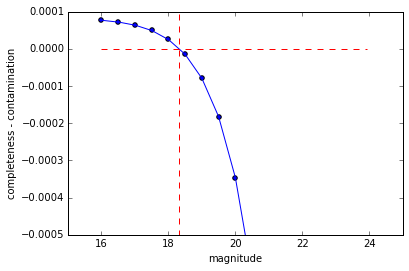

In [9]:
#Plot the results:
plt.scatter(mag,res)
#Interpolate with a cubic spline
f1 = UnivariateSpline(mag,res,k=1,s=0)
#Find the closest approach to zero to the desired resolution
magres = 0.01 #magnitude resolution
magsamples = np.arange(16,np.mean(m5),magres) #sample the magnitude range at this resolution
plt.plot(magsamples,f1(magsamples)) #Plot the interpolated values
plt.xlabel('magnitude')
plt.ylabel('completeness - contamination')
plt.ylim(-0.0005,0.0001)

#Find the closest approach to zero
vardepth = magsamples[np.argmin(np.abs(f1(magsamples)))]
plt.plot([16,np.mean(m5)],[0,0],'--',color='red') #plot zero
#that's the final result
print vardepth
plt.plot([vardepth,vardepth],[-1,1],'--',color='red') #Plot resulting variability depth

plt.show()

So, for this made-up example pointing, we simulate a "variability depth" of ~18.4 mags. Now it's time to write this as a proper metric.

In [10]:
#Calculate the survey depth there a variable star can be reliably identified through a comparsion
#of the measured variance to the measurement uncertainty.

class VarDepth(BaseMetric):
    def __init__(self, m5Col = 'fiveSigmaDepth', 
                 metricName='variability depth', 
                 completeness = .95, contamination = .05, 
                 numruns = 10000, signal = 0.01,
                 magres = 0.01, **kwargs):
        """
        Instantiate metric.
        
        :m5col: the column name of the individual visit m5 data.
        :completeness: fractional desired completeness of recovered variable sample.
        :contamination: fractional allowed incompleteness of recovered nonvariables.
        :numruns: number of simulated realizations of noise (most computationally espensive part).
        :signal: sqrt total pulsational power meant to be recovered.
        :magres: desired resolution of variability depth result."""
        self.m5col = m5Col
        self.completeness = completeness
        self.contamination = contamination
        self.numruns = numruns 
        self.signal = signal
        self.magres = magres
        super(VarDepth, self).__init__(col=m5Col, metricName=metricName, **kwargs)
    def run(self, dataSlice, slicePoint=None):
        #Get the visit information
        m5 = dataSlice[self.m5col]
        #Number of visits
        N = len(m5)
        
        #magnitudes to be sampled
        mag = np.arange(16,np.mean(m5),0.5) 
        #hold the distance between the completeness and contamination goals.
        res = np.zeros(mag.shape) 
        #make them nans for now
        res[:] = np.nan 

        #hold the measured noise-only variances 
        noiseonlyvar = np.zeros(self.numruns)

        #Calculate the variance at a reference magnitude and scale from that
        m0=20.
        sigmaref = 0.2 * (10.**(-0.2*m5)) * (10.**(0.2*m0))

        #run the simulations
        #Simulate the measured noise-only variances at a reference magnitude
        for i in np.arange(self.numruns):
            # random realization of the Gaussian error distributions
            scatter = np.random.randn(N)*sigmaref 
            noiseonlyvar[i] = np.var(scatter) # store the noise-only variance
            
        #Since we are treating the underlying signal being representable by a 
        #fixed-width gaussian, its variance pdf is a Chi-squared distribution 
        #with the degrees of freedom = visits. Since variances add, the variance 
        #pdfs convolve. The cumulative distribution function of the sum of two 
        #random deviates is the convolution of one pdf with a cdf. 

        #We'll consider the cdf of the noise-only variances because it's easier 
        #to interpolate
        noisesorted = np.sort(noiseonlyvar)
        #linear interpolation
        interpnoisecdf = UnivariateSpline(noisesorted,np.arange(self.numruns)/float(self.numruns),k=1,s=0)

        #We need a binned, signal-only variance probability distribution function for numerical convolution
        numsignalsamples = 100
        xsig = np.linspace(chi2.ppf(0.001, N),chi2.ppf(0.999, N),numsignalsamples)
        signalpdf = chi2.pdf(xsig, N)
        #correct x to the proper variance scale
        xsig = (self.signal**2.)*xsig/N
        pdfstepsize = xsig[1]-xsig[0]
        #Since everything is going to use this stepsize down the line,
        #normalize so the pdf integrates to 1 when summed (no factor of stepsize needed)
        signalpdf /= np.sum(signalpdf)

        #run through the sample magnitudes, calculate distance between cont 
        #and comp thresholds.
        #run until solution found.
        solutionfound=False
        
        for i,mref in enumerate(mag): 
            #i counts and mref is the currently sampled magnitude
            #Scale factor from m0
            scalefact = 10.**(0.4*(mref-m0))

            #Calculate the desired contamination threshold
            contthresh = np.percentile(noiseonlyvar,100.-100.*self.contamination)*scalefact

            #Realize the noise CDF at the required stepsize
            xnoise = np.arange(noisesorted[0]*scalefact,noisesorted[-1]*scalefact,pdfstepsize)
            
            #Only do calculation if near the solution:
            if (len(xnoise) > numsignalsamples/10) and (not solutionfound):
                noisecdf = interpnoisecdf(xnoise/scalefact)
                noisepdf = (noisecdf[1:]-noisecdf[:-1]) #turn into a noise pdf
                noisepdf /= np.sum(noisepdf)
                xnoise = (xnoise[1:]+xnoise[:-1])/2. #from cdf to pdf conversion

                #calculate and plot the convolution = signal+noise variance dist.
                convolution=0
                if len(noisepdf) > len(signalpdf):
                    convolution = np.convolve(noisepdf,signalpdf)
                else: 
                    convolution = np.convolve(signalpdf,noisepdf)
                xconvolved = xsig[0]+xnoise[0]+np.arange(len(convolution))*pdfstepsize

                #calculate the completeness threshold
                combinedcdf = np.cumsum(convolution)
                findcompthresh = UnivariateSpline(combinedcdf,xconvolved,k=1,s=0)
                compthresh = findcompthresh(1.-self.completeness)

                res[i] = compthresh - contthresh
                if res[i] < 0: solutionfound = True
        
        #interpolate for where the thresholds coincide
        #print res
        if np.sum(np.isfinite(res)) > 1:
            f1 = UnivariateSpline(mag[np.isfinite(res)],res[np.isfinite(res)],k=1,s=0)
            #sample the magnitude range at given resolution
            magsamples = np.arange(16,np.mean(m5),self.magres) 
            vardepth = magsamples[np.argmin(np.abs(f1(magsamples)))]
            return vardepth
        else:
            return min(mag)-1

In [11]:
#And test it out:
metric = VarDepth('fiveSigmaDepth',numruns=100) #Note: default numruns=10000 takes way too long.
slicer = slicers.HealpixSlicer(nside=64)
sqlconstraint = 'filter = "r"'
myBundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [ ]:
#Run it:
opsdb = db.OpsimDatabase('enigma_1189_sqlite.db')
bgroup = metricBundles.MetricBundleGroup({0: myBundle}, opsdb, outDir='newmetric_test', resultsDb=None)
bgroup.runAll()

Querying database with constraint filter = "r"
Found 544710 visits

In [ ]:
myBundle.setPlotDict({'colorMin':16.1, 'colorMax':20.5})
bgroup.plotAll(closefigs=False,dpi=600,figformat='png')